In [3]:
from dotenv import load_dotenv
load_dotenv()

from argparse import ArgumentParser
import warnings
from collections import OrderedDict
import json
import io
import os
import sys
import pickle
import base64
from traceback import print_exc

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.sampler as sampler
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from time import sleep, time

import matplotlib.pyplot as plt

import logging

from non_iid_generator.customDataset import CustomDataset

DEVICE = "cuda"

In [287]:
conf = json.loads(open("data/Cifar10_NIID_a01_140c/config.json", "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

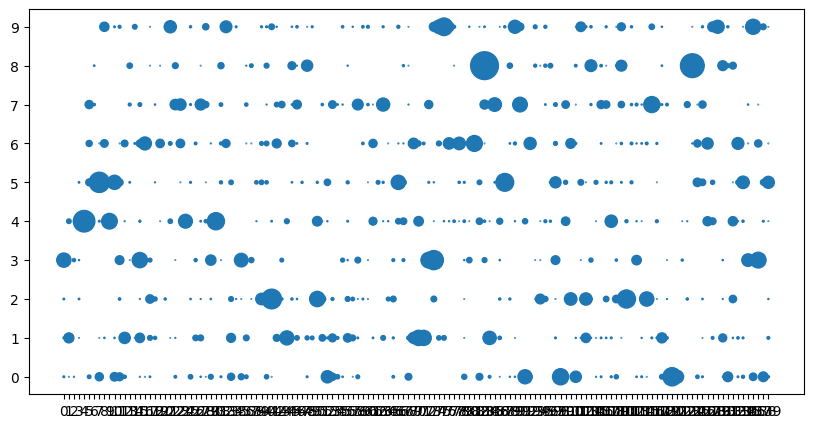

In [290]:
df = pd.DataFrame(data).replace(np.nan, 0)
x = np.array(np.meshgrid(np.arange(140),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(140),np.arange(10))).T.reshape(-1,2)[:,1]
s = df.values.reshape(1,-1)[0].astype("int")
s = (s - np.amin(s))/(np.amax(s) - np.amin(s))*400

plt.figure(figsize=(10,5))
plt.scatter(x,y,s)
plt.xticks(np.arange(140))
plt.yticks(np.arange(10))
plt.show()

In [291]:
main_label_vectors = np.zeros((140,10))

for client_id in range(140):
    for class_id in range(10):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

- Groups should have uniform distribution
- Each group should have similar average bandwidths
---

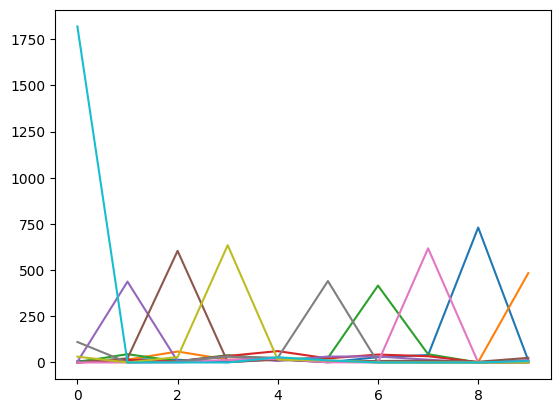

[[   7    0    2    0    3    0    0  111   31 1819]
 [  18   15   45   13  437   22    0    0    0    0]
 [  14   59    6    6    6  604    0    5   29    0]
 [   1   15   39   35   32    2   14   31  634    0]
 [  18   17   17   61    7   14   20   25   15   28]
 [   1    7   24   22   32    2    1  440   11   11]
 [  28    6  416   42   32    8    0    0    0    0]
 [  40    0   44   33   15    9  618    0    0    0]
 [ 730    2    0    1    0    4    0    0    0    0]
 [  10  483    1    1   12   24    0    0    0    7]]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 2, 10,  7,  7, 78,  8,  8,  7,  5,  8]))
[[  16   22   48   20    9   16   19   25   15   28]
 [  40    0   44   33   15    9  618    0    0    0]
 [   7    0    2    0    3    0    0  111   31 1819]
 [   1   15   39   35   32    2   14   31  634    0]
 [ 730    1    0    1    0    3    0    0    0    0]
 [  17   14   72   12  421   20    0    0    0    0]
 [  45   13   62  436    0    0    0    0    0    0]
 [  14   

/home/goktug/python_envs/easyfl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


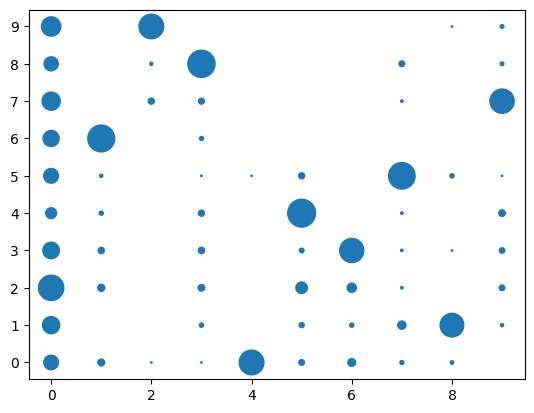

In [263]:
centroids = np.random.choice(140, 10, replace=False)
centroids
main_label_vectors[centroids]

def kmeans(X, k, max_iters=100, tol=1e-4):
    """
    K-means clustering algorithm.

    Parameters:
    - X: Input data, a numpy array with shape (n_samples, n_features).
    - k: Number of clusters.
    - max_iters: Maximum number of iterations.
    - tol: Tolerance to declare convergence.

    Returns:
    - centroids: Final cluster centers, a numpy array with shape (k, n_features).
    - labels: Assignments of each data point to a cluster, a numpy array with shape (n_samples,).
    """

    n_samples, n_features = X.shape

    # Initialize centroids randomly
    centroids = X[np.random.choice(n_samples, k, replace=False)]

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels

centroids, labels = kmeans(main_label_vectors,10,max_iters=100)
np.unique(labels, return_counts=True)
plt.plot(centroids)
plt.show()
print(centroids.astype(int))
print(np.unique(labels, return_counts=True))

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(main_label_vectors)
centroids = kmeans.cluster_centers_
print(centroids.astype(int))
print(np.unique(labels, return_counts=True))

class_dist = np.repeat(np.zeros(len(np.unique(labels))).reshape(-1,1),10,axis=1)
for label in np.unique(labels):
    class_dist[label] = np.sum(main_label_vectors[labels == label], axis=0)

x = np.array(np.meshgrid(np.arange(len(np.unique(labels))),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(labels))),np.arange(10))).T.reshape(-1,2)[:,1]
s = class_dist.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))
plt.show()



ITER NO : 0
NO GROUPS : 70
ITER NO : 1
NO GROUPS : 36
ITER NO : 2
NO GROUPS : 19
ITER NO : 3
NO GROUPS : 10
ITER NO : 4
NO GROUPS : 6


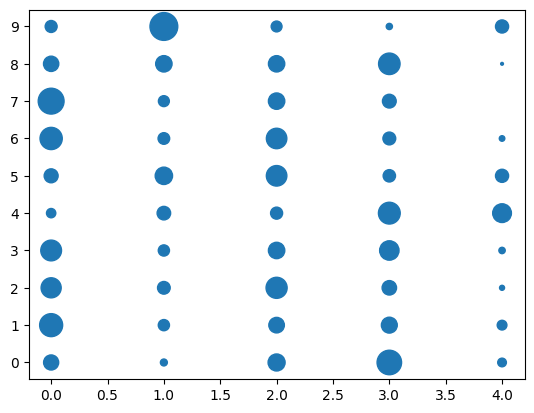

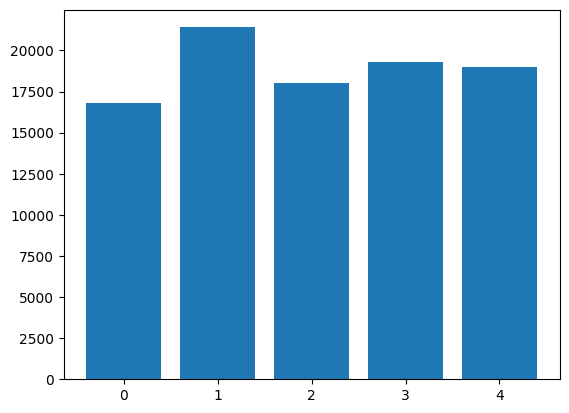

In [331]:
import math
from copy import deepcopy
import random

def dist(Z_i,Z_j):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    Z_ij = Z_i+Z_j
    return magnitude(Z_ij/magnitude(Z_ij) - Z_global/magnitude(Z_global)) #+ (magnitude(np.sqrt(zi*zj)) / magnitude(Z_global))



label_vectors = deepcopy(main_label_vectors)
dataset_sizes = np.sum(label_vectors, axis=1)
label_vectors = np.asarray([label_vectors[idx] for _, idx in sorted(zip(dataset_sizes, np.arange(len(label_vectors))), reverse=True)])

delay = np.repeat(np.repeat(np.arange(1,100,10), 14).reshape(-1,1),10, axis=1)
np.random.shuffle(delay)
# label_vectors = np.multiply(label_vectors,delay)

h = np.sum(label_vectors * delay, axis = 1)
limit = 0
limit = np.percentile(h,100)
thresh_delay = np.sum(label_vectors * delay, axis = 1)
delay = delay[thresh_delay < limit]
label_vectors = label_vectors[thresh_delay < limit]

NO_CLIENTS = len(label_vectors)
N = 20
NO_ITER = 6
main_groups = np.zeros(NO_CLIENTS, dtype=int)

groups = deepcopy(main_groups)


NO_GROUPS = NO_CLIENTS
for iterno in range(NO_ITER-1):
    print(f"ITER NO : {iterno}")

    Z_global = np.sum(label_vectors,axis=0)
    cnt = 1

    while 0 in groups:
        #select client
        client_k = None
        for i in range(len(label_vectors)):
            if groups[i] == 0:
                client_k = i
                break
        # client_k = random.choice([i for i in range(len(label_vectors)) if groups[i] == 0])

        
        

        client_l = None
        while True:

            client_j = np.argmin([dist(label_vectors[client_k],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
            client_l = np.argmin([dist(label_vectors[client_j],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
            
            if client_l != client_k:
                client_k = client_l
                continue
            else: break
        # print("------")
                
        groups[client_k] = cnt
        groups[client_j] = cnt

        cnt += 1

    NO_GROUPS = len(np.unique(groups))
    print("NO GROUPS :", NO_GROUPS)
    new_label_vectors = np.zeros((NO_GROUPS,10))
    for idx, group_id in enumerate(np.unique(groups)):
        new_label_vectors[idx] = np.sum(label_vectors[groups == group_id], axis=0)

    label_vectors = new_label_vectors


    # groupMap = dict(zip(np.arange(len(main_groups)), groups))
    
    # break

    # print(groups)
    if iterno == 0:
        main_groups = deepcopy(groups)
    else:
        for idx in range(1,len(groups)+1):
            for main_idx in range(len(main_groups)):
                if main_groups[main_idx] == idx:
                    main_groups[main_idx] = groups[idx-1]

    prev_groups = deepcopy(groups)
    groups = np.zeros(NO_GROUPS, dtype=int)
    # print(np.unique(main_groups, return_counts=True))
    # print(np.unique(main_groups, return_counts=True)[0])
    # print(dict(zip(np.unique(main_groups, return_counts=True))))


new_label_vectors = np.zeros((len(np.unique(main_groups)),10))
delays = np.zeros((len(np.unique(main_groups))))
temp_label_vectors = main_label_vectors[thresh_delay < limit]
main_delay = np.sum(temp_label_vectors * delay, axis = 1)
for idx, group_id in enumerate(np.unique(main_groups)):
    new_label_vectors[idx] = np.sum(temp_label_vectors[main_groups == group_id], axis=0)
    delays[idx] = np.mean(main_delay[main_groups == group_id])


x = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,1]
s = new_label_vectors.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))
plt.show()

h = delays
plt.bar(x=np.arange(len(h)), height=h)
plt.show()

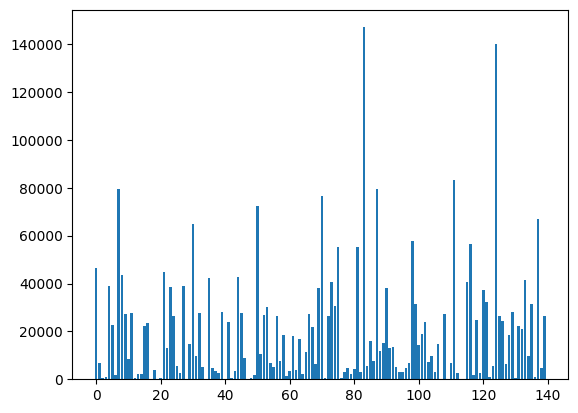

In [267]:
h = np.sum(main_label_vectors * delay, axis = 1)
plt.bar(np.arange(len(h)), h)
plt.show()

NO GROUPS : 7


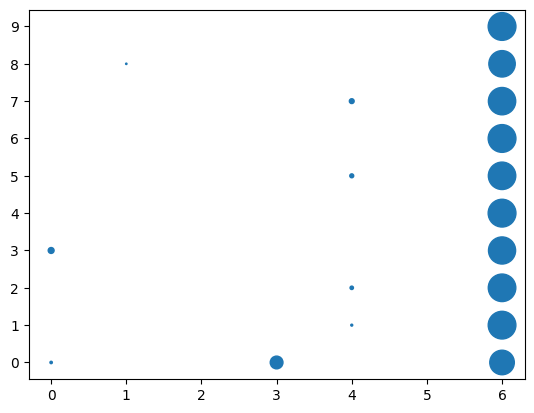

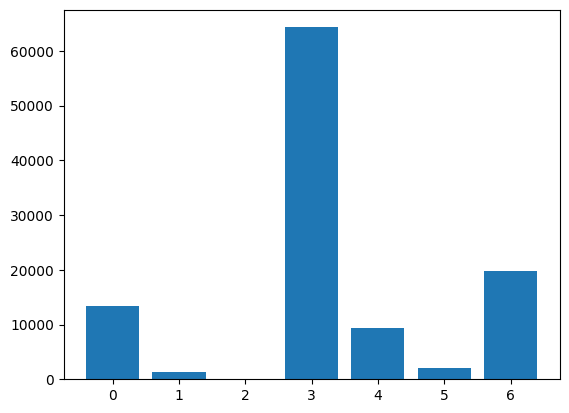

In [389]:
import math
from copy import deepcopy
import random

def dist(Z_i,Z_j):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    Z_ij = Z_i+Z_j
    return magnitude(Z_ij/magnitude(Z_ij) - Z_global/magnitude(Z_global)) + (magnitude(Z_j - Z_i) / magnitude(Z_global))



label_vectors = deepcopy(main_label_vectors)
dataset_sizes = np.sum(label_vectors, axis=1)
label_vectors = np.asarray([label_vectors[idx] for _, idx in sorted(zip(dataset_sizes, np.arange(len(label_vectors))), reverse=True)])
dataset_sizes = np.sum(label_vectors, axis=1)

delay = np.repeat(np.repeat(np.arange(1,100,10), 14).reshape(-1,1),10, axis=1)
np.random.shuffle(delay)
# label_vectors = np.multiply(label_vectors,delay)

h = np.sum(label_vectors * delay, axis = 1)
limit = 0
limit = np.percentile(h,100)
thresh_delay = np.sum(label_vectors * delay, axis = 1)
delay = delay[thresh_delay < limit]
label_vectors = label_vectors[thresh_delay < limit]

NO_CLIENTS = len(label_vectors)
N = 20
NO_ITER = 6
main_groups = np.zeros(NO_CLIENTS, dtype=int)

groups = deepcopy(main_groups)


NO_GROUPS = 7
group_dist = []
for no in range(NO_GROUPS):
    group_dist.append(np.zeros(10))

Z_global = np.sum(label_vectors,axis=0)

client_k = None
for i in range(len(label_vectors)):
    if groups[i] == 0:
        client_k = i
    else: continue

    if i < NO_GROUPS:
        group_id = i
    # else:
    #     group_id = np.argmin([dist(label_vectors[client_k],group_dist[j]) for j in range(NO_GROUPS)])
    
    groups[client_k] = group_id
    group_dist[group_id] = np.sum([group_dist[group_id],label_vectors[client_k]], axis=0)


    # client_l = None
    # while True:

    #     client_j = np.argmin([dist(label_vectors[client_k],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
    #     client_l = np.argmin([dist(label_vectors[client_j],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
        
    #     if client_l != client_k:
    #         client_k = client_l
    #         continue
    #     else: break
    # # print("------")
            
    # groups[client_k] = cnt
    # groups[client_j] = cnt

    # cnt += 1

NO_GROUPS = len(np.unique(groups))
print("NO GROUPS :", NO_GROUPS)
new_label_vectors = np.zeros((NO_GROUPS,10))
for idx, group_id in enumerate(np.unique(groups)):
    new_label_vectors[idx] = np.sum(label_vectors[groups == group_id], axis=0)

main_groups = deepcopy(groups)

new_label_vectors = np.zeros((len(np.unique(main_groups)),10))
delays = np.zeros((len(np.unique(main_groups))))
temp_label_vectors = main_label_vectors[thresh_delay < limit]
main_delay = np.sum(temp_label_vectors * delay, axis = 1)
for idx, group_id in enumerate(np.unique(main_groups)):
    new_label_vectors[idx] = np.sum(temp_label_vectors[main_groups == group_id], axis=0)
    delays[idx] = np.mean(main_delay[main_groups == group_id])


x = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,1]
s = new_label_vectors.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))
plt.show()

h = delays
plt.bar(x=np.arange(len(h)), height=h)
plt.show()

In [408]:
def dist(Z_i,Z_j):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    Z_ij = Z_i+Z_j
    firstpart = magnitude(Z_ij/magnitude(Z_ij) - Z_global/magnitude(Z_global))
    secondpart = magnitude(Z_j - Z_i) / magnitude(Z_j + Z_i)
    print(f"f: {firstpart}")
    print(f"s: {secondpart}")
    return firstpart+secondpart

magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))


Z_j = group_dist[2]
Z_i = main_label_vectors[0]
Z_ij = Z_i+Z_j

print(magnitude(Z_ij/magnitude(Z_ij) - Z_global/magnitude(Z_global)))
print(magnitude(Z_j - Z_i) / magnitude(Z_j + Z_i))
print(dist(Z_i,Z_j))

1.0121866135199877
0.9981604051346309
f: 1.0121866135199877
s: 0.9981604051346309
2.0103470186546186


In [366]:
np.sum(label_vectors[5])

1146.0

In [330]:
sorted(dataset_sizes, reverse=True)

[2410.0,
 1538.0,
 1306.0,
 1303.0,
 1261.0,
 1146.0,
 1054.0,
 945.0,
 914.0,
 906.0,
 903.0,
 894.0,
 875.0,
 854.0,
 825.0,
 801.0,
 793.0,
 770.0,
 756.0,
 745.0,
 711.0,
 683.0,
 677.0,
 664.0,
 664.0,
 660.0,
 640.0,
 627.0,
 626.0,
 618.0,
 614.0,
 613.0,
 601.0,
 601.0,
 597.0,
 574.0,
 572.0,
 565.0,
 546.0,
 545.0,
 544.0,
 543.0,
 530.0,
 517.0,
 517.0,
 511.0,
 499.0,
 494.0,
 493.0,
 493.0,
 492.0,
 480.0,
 470.0,
 469.0,
 465.0,
 463.0,
 460.0,
 459.0,
 456.0,
 454.0,
 448.0,
 448.0,
 446.0,
 444.0,
 442.0,
 441.0,
 441.0,
 440.0,
 439.0,
 435.0,
 431.0,
 429.0,
 426.0,
 418.0,
 397.0,
 387.0,
 372.0,
 356.0,
 354.0,
 351.0,
 339.0,
 328.0,
 311.0,
 302.0,
 301.0,
 299.0,
 294.0,
 291.0,
 286.0,
 274.0,
 261.0,
 258.0,
 254.0,
 239.0,
 238.0,
 223.0,
 210.0,
 209.0,
 194.0,
 190.0,
 164.0,
 158.0,
 155.0,
 152.0,
 150.0,
 147.0,
 147.0,
 140.0,
 135.0,
 127.0,
 126.0,
 112.0,
 108.0,
 102.0,
 88.0,
 83.0,
 78.0,
 78.0,
 77.0,
 72.0,
 70.0,
 65.0,
 64.0,
 63.0,
 58.0,
 45.

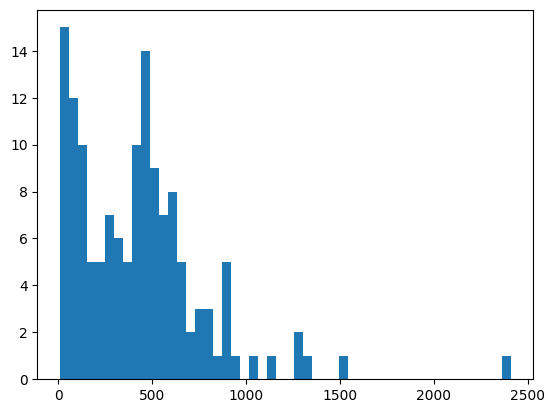

In [319]:
plt.hist(dataset_sizes, 50)
plt.show()